###Auto Regression Moving Average

In [1]:
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [2]:
url="/content/co2_mm_mlo.csv"
names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')
df=pd.read_csv(url,skiprows=72,names=names,index_col=False)
df

year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0    1960     10     1960.7896   313.83          316.83     -1 -9.99 -0.99
1    1960     11     1960.8743   315.00          316.88     -1 -9.99 -0.99
2    1960     12     1960.9563   316.19          316.96     -1 -9.99 -0.99
3    1961      1     1961.0411   316.89          316.86     -1 -9.99 -0.99
4    1961      2     1961.1260   317.70          317.08     -1 -9.99 -0.99
..    ...    ...           ...      ...             ...    ...   ...   ...
756  2023     10     2023.7917   418.82          422.12     27  0.47  0.17
757  2023     11     2023.8750   420.46          422.46     21  0.91  0.38
758  2023     12     2023.9583   421.86          422.58     20  0.68  0.29
759  2024      1     2024.0417   422.80          422.45     27  0.73  0.27
760  2024      2     2024.1250   424.55          423.61     18  1.31  0.59

[761 rows x 8 columns]

In [3]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

In [4]:
df.head()

year  month  decimal date  average  deseasonalized  ndays  sdev  \
1960-10-01  1960     10     1960.7896   313.83          316.83     -1 -9.99   
1960-11-01  1960     11     1960.8743   315.00          316.88     -1 -9.99   
1960-12-01  1960     12     1960.9563   316.19          316.96     -1 -9.99   
1961-01-01  1961      1     1961.0411   316.89          316.86     -1 -9.99   
1961-02-01  1961      2     1961.1260   317.70          317.08     -1 -9.99   

             unc  
1960-10-01 -0.99  
1960-11-01 -0.99  
1960-12-01 -0.99  
1961-01-01 -0.99  
1961-02-01 -0.99

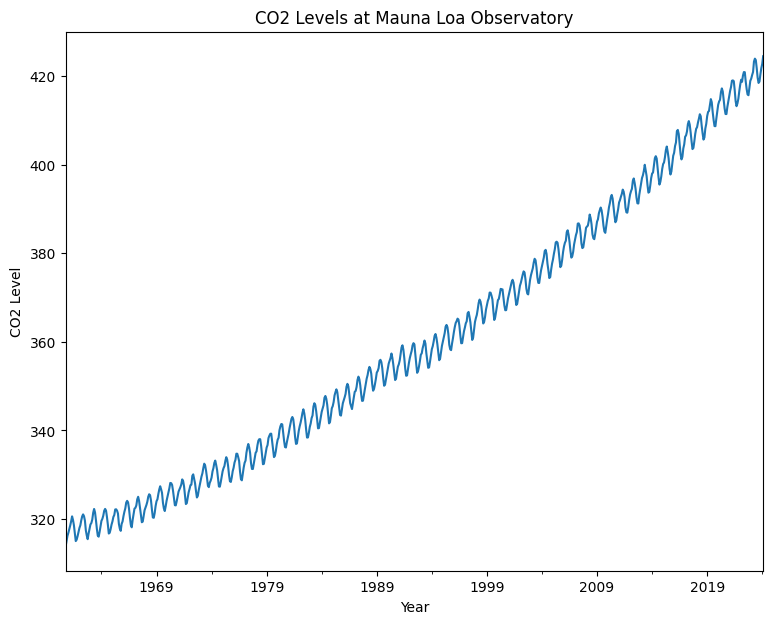

In [5]:
df.average.plot(figsize=(9,7),title="CO2 Levels at Mauna Loa Observatory")
plt.xlabel("Year")
plt.ylabel("CO2 Level")
plt.show()

In [6]:
df = df[["average"]]

In [7]:
df.head()

average
1960-10-01   313.83
1960-11-01   315.00
1960-12-01   316.19
1961-01-01   316.89
1961-02-01   317.70

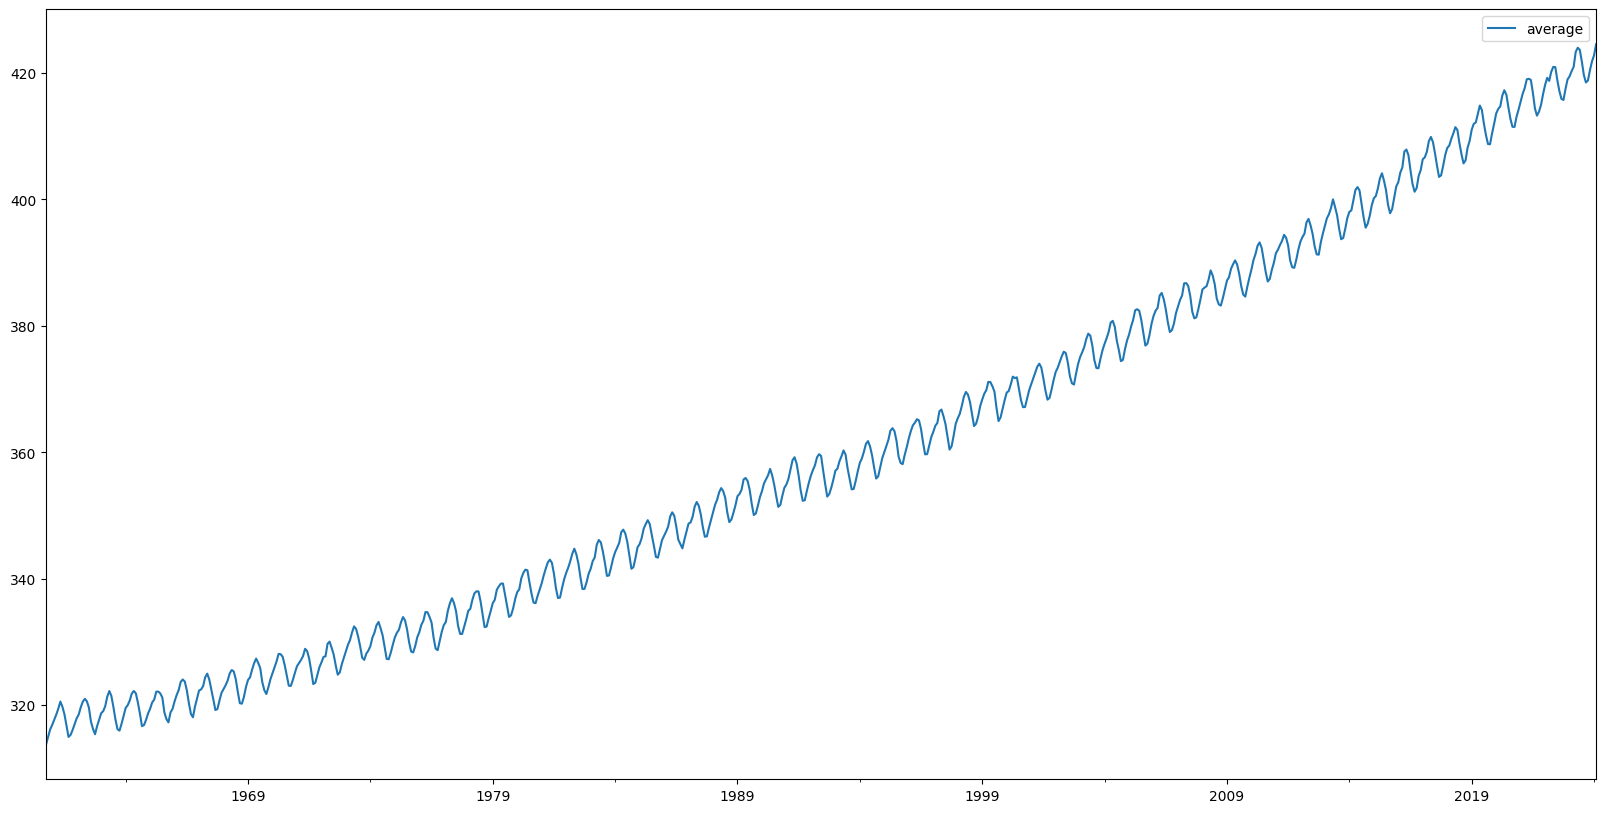

In [8]:
df.plot(figsize = (20,10))
plt.show()

<Axes: >

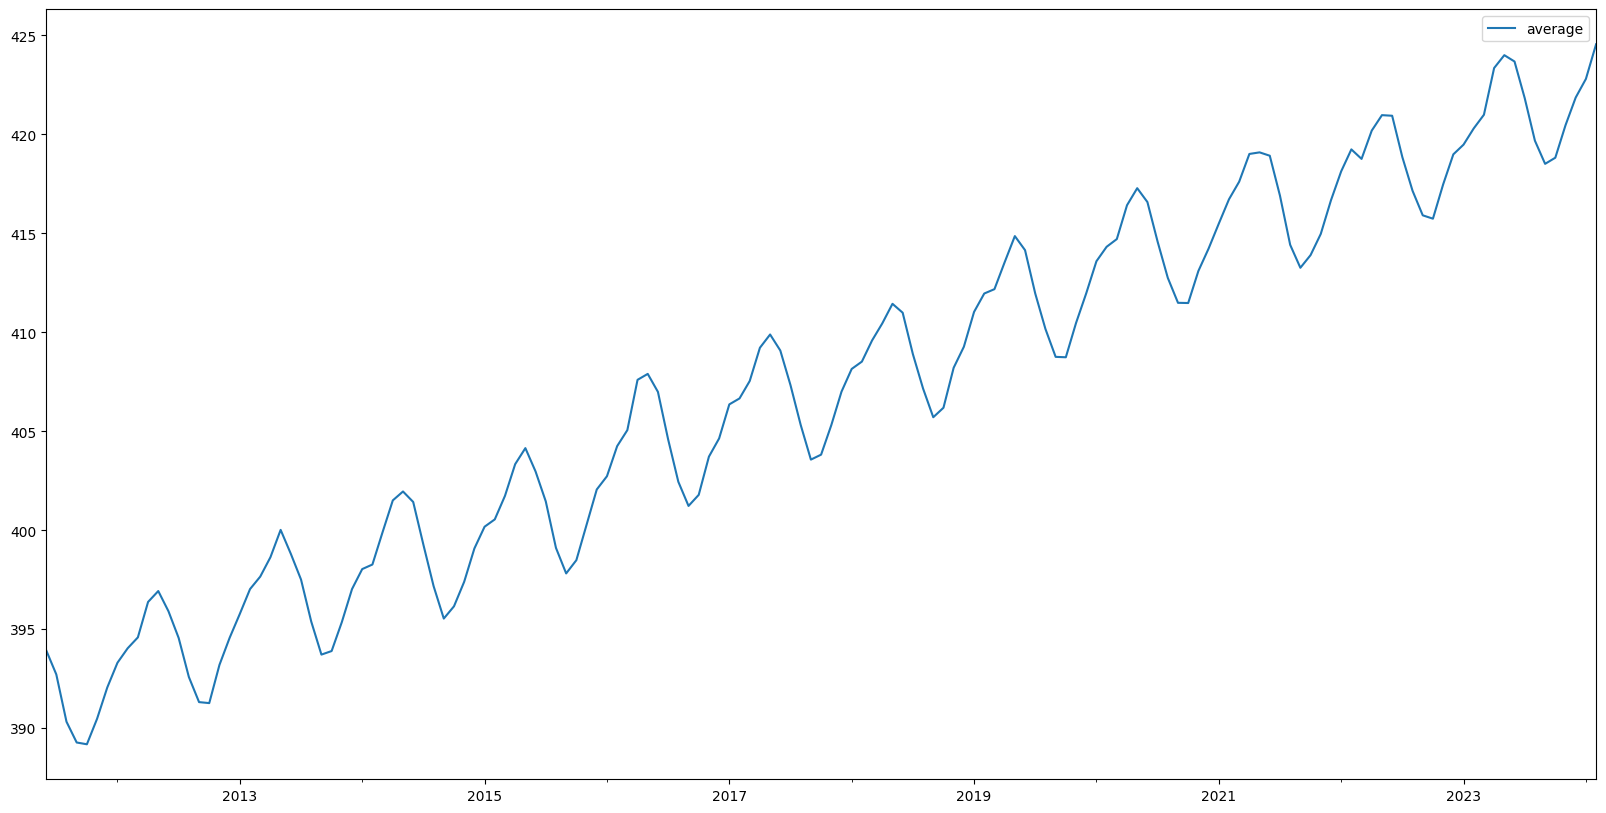

In [9]:
df[608:].plot(figsize = (20,10))

In [10]:
adfuller_result = adfuller(df.dropna())
pvalue = adfuller_result[1]
print(adfuller_result)
if pvalue < 0.05:
    print("stationary")
else:
    print("non-stationary")

(5.177591943681344, 1.0, 20, 740, {'1%': -3.4392177416762086, '5%': -2.8654536415414684, '10%': -2.5688540485756026}, 566.5559602604742)
non-stationary


In [11]:
adfuller_result = adfuller(df.dropna().diff().dropna())
pvalue = adfuller_result[1]
print(adfuller_result)
if pvalue < 0.05:
    print("stationary")
else:
    print("non-stationary")

(-4.747442953762944, 6.847857728421295e-05, 20, 739, {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}, 583.7527962841186)
stationary


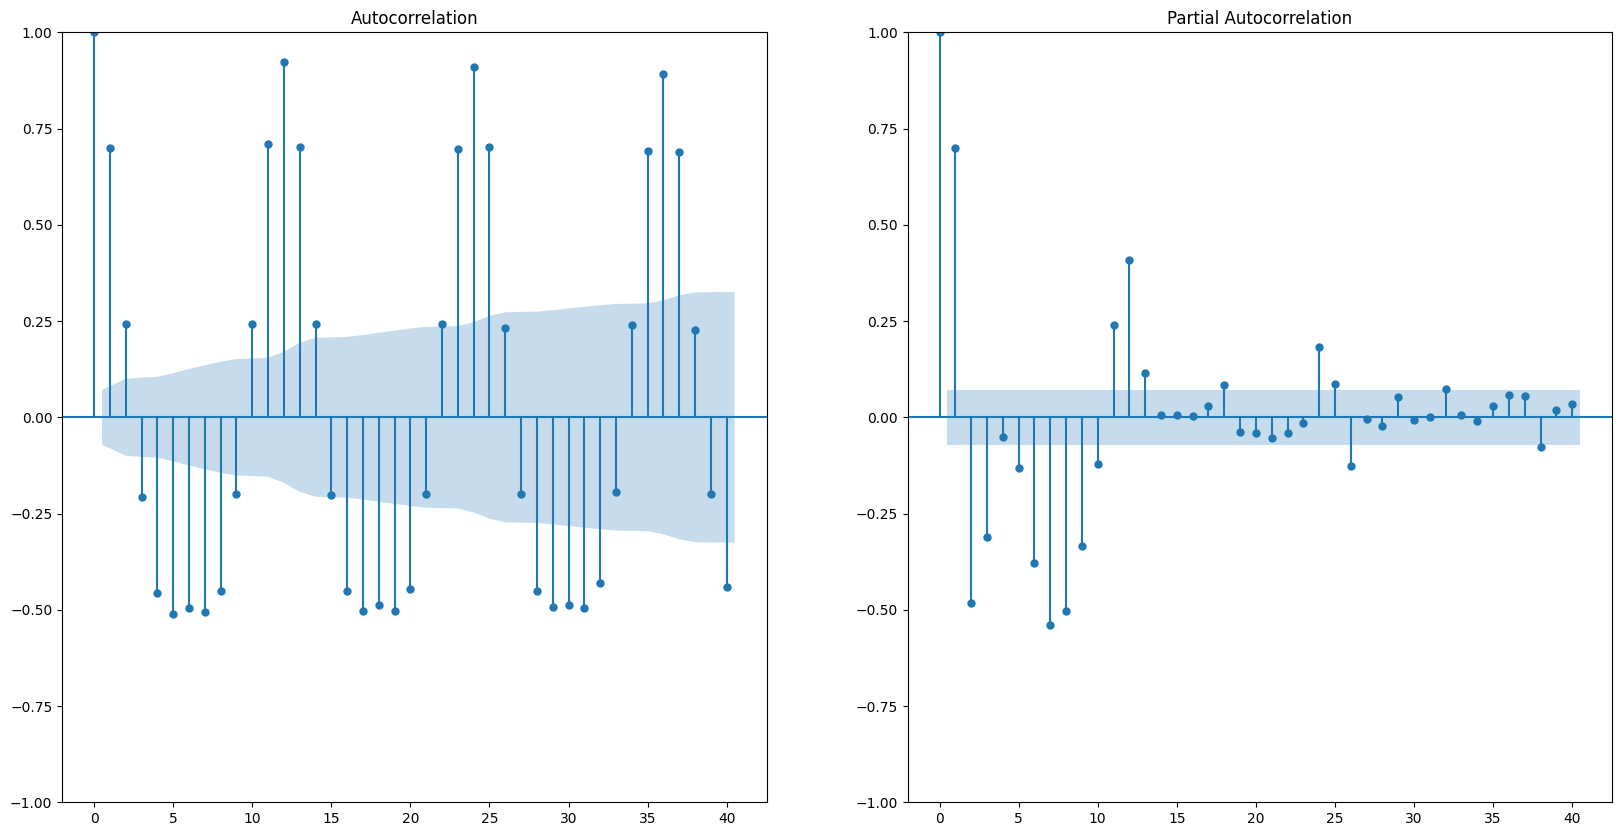

In [12]:
fig, (ax1,ax2) = plt.subplots(figsize = (20,10), ncols = 2)
plot_acf(df.diff().dropna(), ax = ax1, lags = 40)
plot_pacf(df.diff().dropna(), ax = ax2, lags = 40)
plt.show()

761


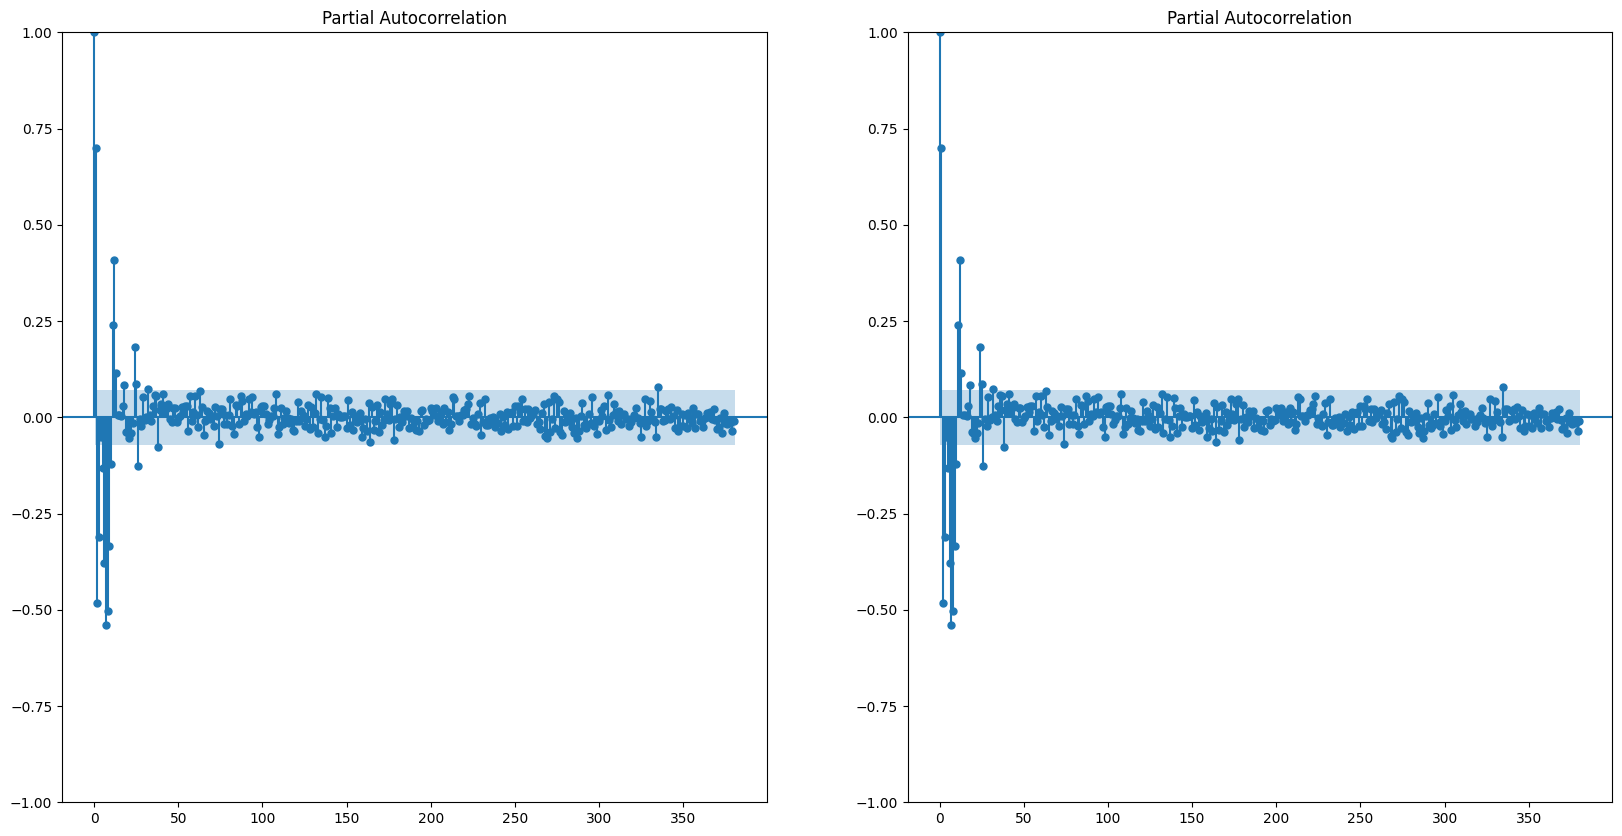

In [13]:
fig, (ax1,ax2) = plt.subplots(figsize = (20,10), ncols = 2)
plot_pacf(df.diff().dropna(), ax = ax1, lags = 380)
plot_pacf(df.diff().dropna(), ax = ax2, lags = 380)
print(df.shape[0])
plt.show()

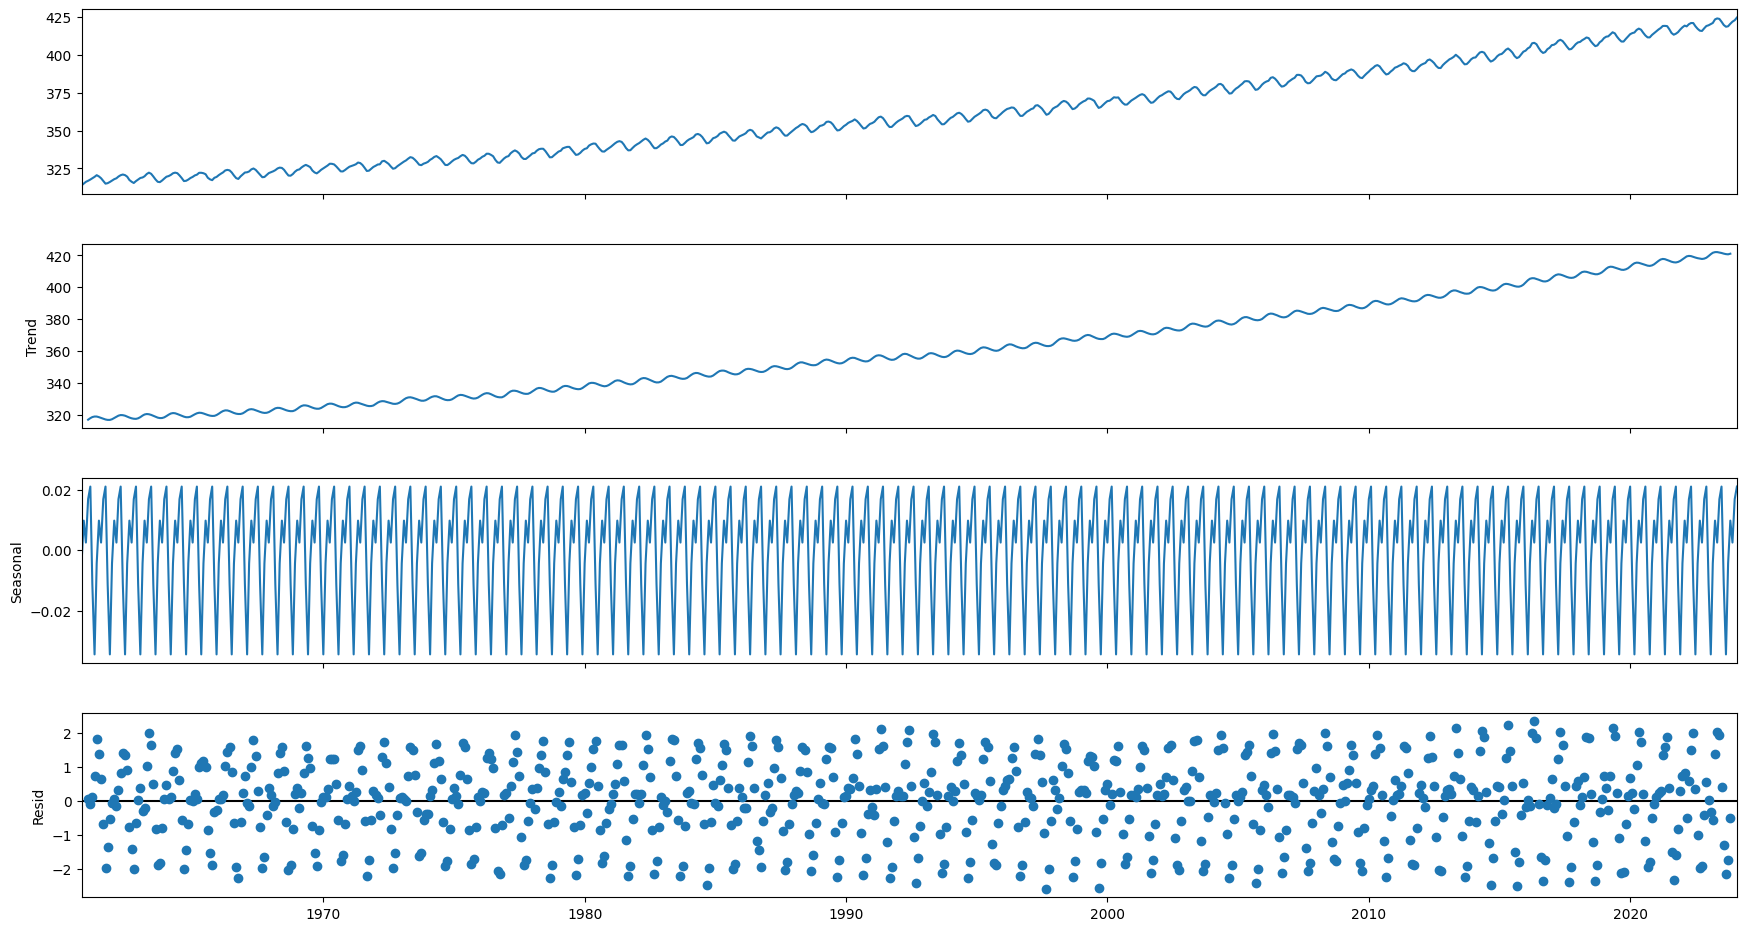

In [14]:
decompose = seasonal_decompose(df.dropna(), period = 7).plot()
decompose.set_size_inches((20,10))
plt.show()

In [15]:
train, test = train_test_split(df, test_size = 0.2,random_state = 13, shuffle = False)
p, d, q = 1,1,1
fcst = []
for step in range(test.shape[0]):
    try:
        arima = ARIMA(train, order = (p,d,q))
        arima_final = arima.fit()
        prediction = arima_final.forecast(steps = 1)
        fcst.append(prediction[0])
        train = train.append(pd.Series(test.iloc[step]))
    except:
        error = -99999
        print("error")
        fcst.append(error)
        tmp = test.iloc[step]
        tmp[0] = error
        train = train.append(pd.Series(tmp))

In [16]:
print(arima_final.summary())

                               SARIMAX Results                                
Dep. Variable:                average   No. Observations:                  760
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -934.591
Date:                Thu, 21 Mar 2024   AIC                           1875.182
Time:                        12:19:15   BIC                           1889.078
Sample:                    10-01-1960   HQIC                          1880.534
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5672      0.042     13.614      0.000       0.486       0.649
ma.L1          0.3581      0.046      7.780      0.000       0.268       0.448
sigma2         0.6863      0.041     16.818      0.0

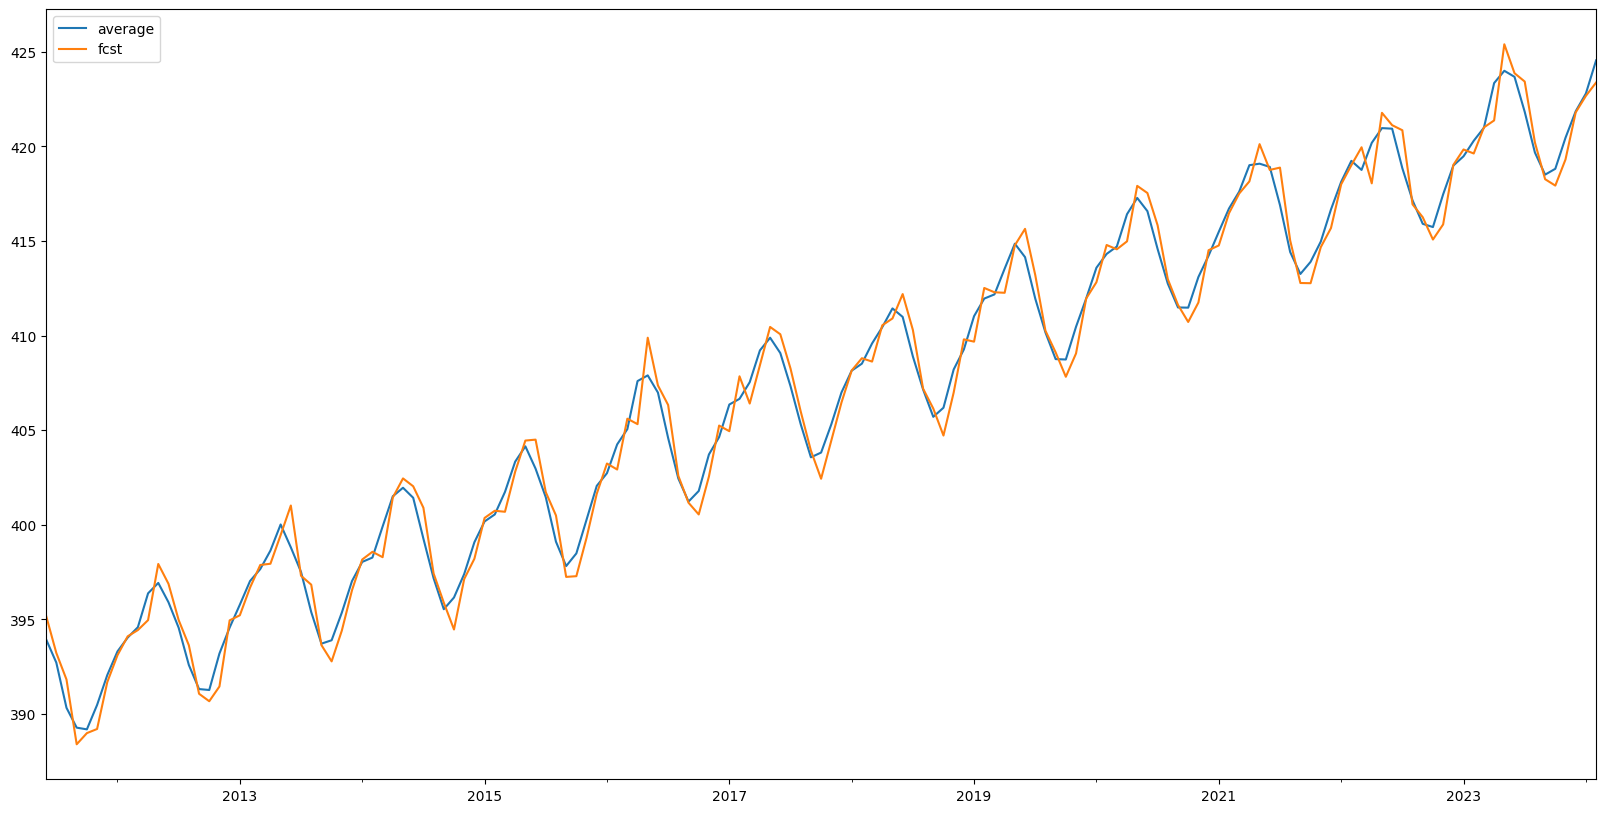

In [17]:
test["fcst"] = fcst
test.plot(figsize = (20,10))
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error

mse_score = mean_squared_error(test['average'], test['fcst'])
print(mse_score)

0.8991050570443994


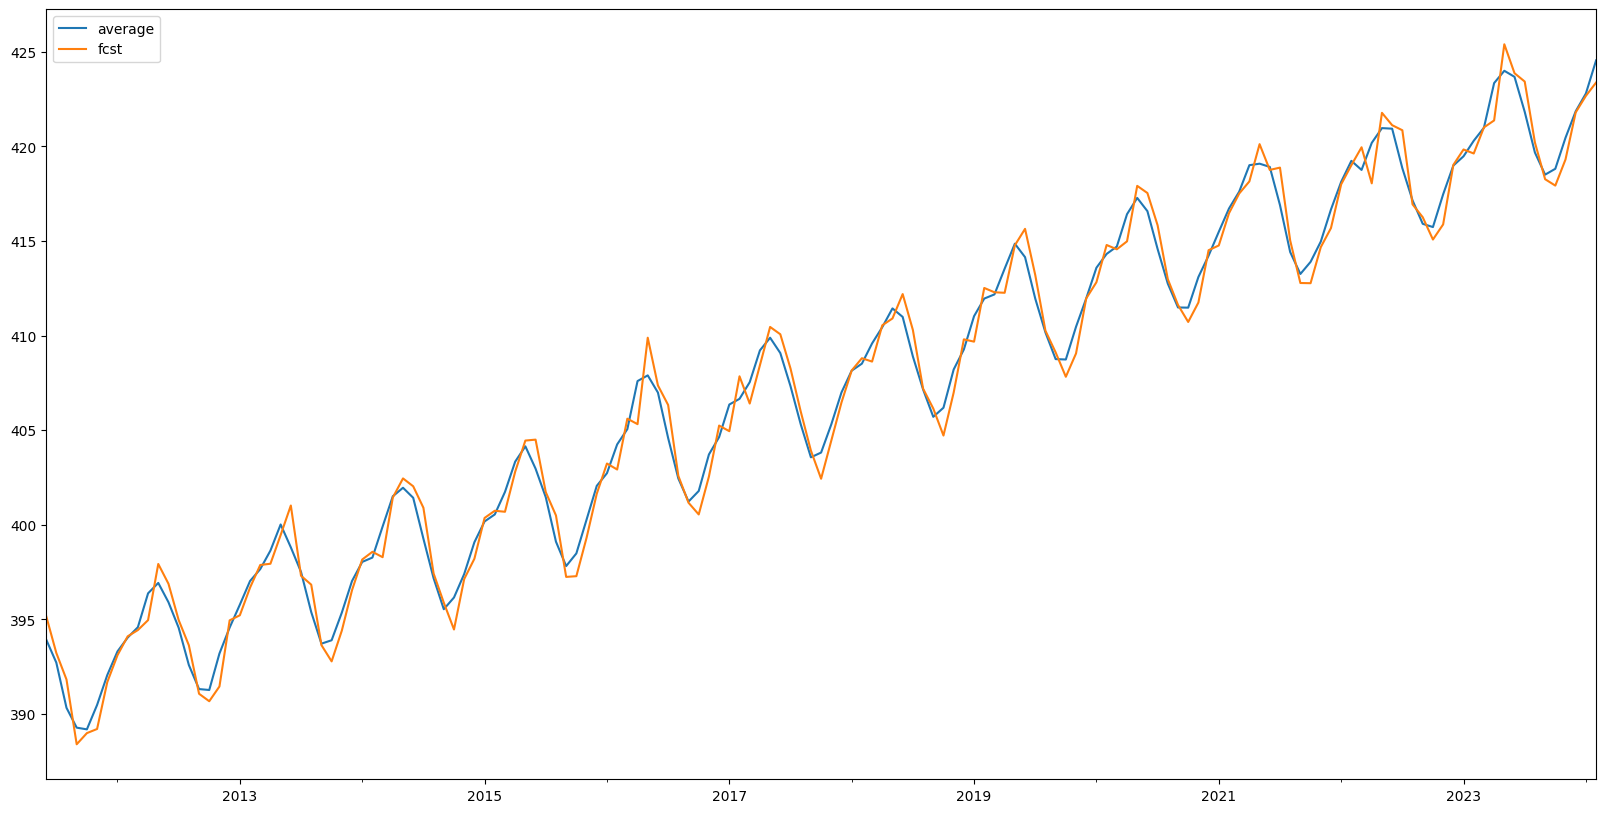

In [19]:

test["fcst"] = fcst
test.plot(figsize = (20,10))
plt.show()

In [20]:
train, test = train_test_split(df, test_size = 0.2,random_state = 13, shuffle = False)
p, d, q = 0,0,1
fcst = []
for step in range(test.shape[0]):
    try:
        arima = ARIMA(train, order = (p,d,q))
        arima_final = arima.fit()
        prediction = arima_final.forecast(steps = 1)
        fcst.append(prediction[0])
        train = train.append(pd.Series(test.iloc[step]))
    except:
        error = -99999
        print("error")
        fcst.append(error)
        tmp = test.iloc[step]
        tmp[0] = error
        train = train.append(pd.Series(tmp))

In [21]:
print(arima_final.summary())

                               SARIMAX Results                                
Dep. Variable:                average   No. Observations:                  760
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3164.877
Date:                Thu, 21 Mar 2024   AIC                           6335.755
Time:                        12:20:40   BIC                           6349.655
Sample:                    10-01-1960   HQIC                          6341.107
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        360.5244      1.190    302.993      0.000     358.192     362.857
ma.L1          0.9958      0.004    247.033      0.000       0.988       1.004
sigma2       240.9053     18.922     12.731      0.0

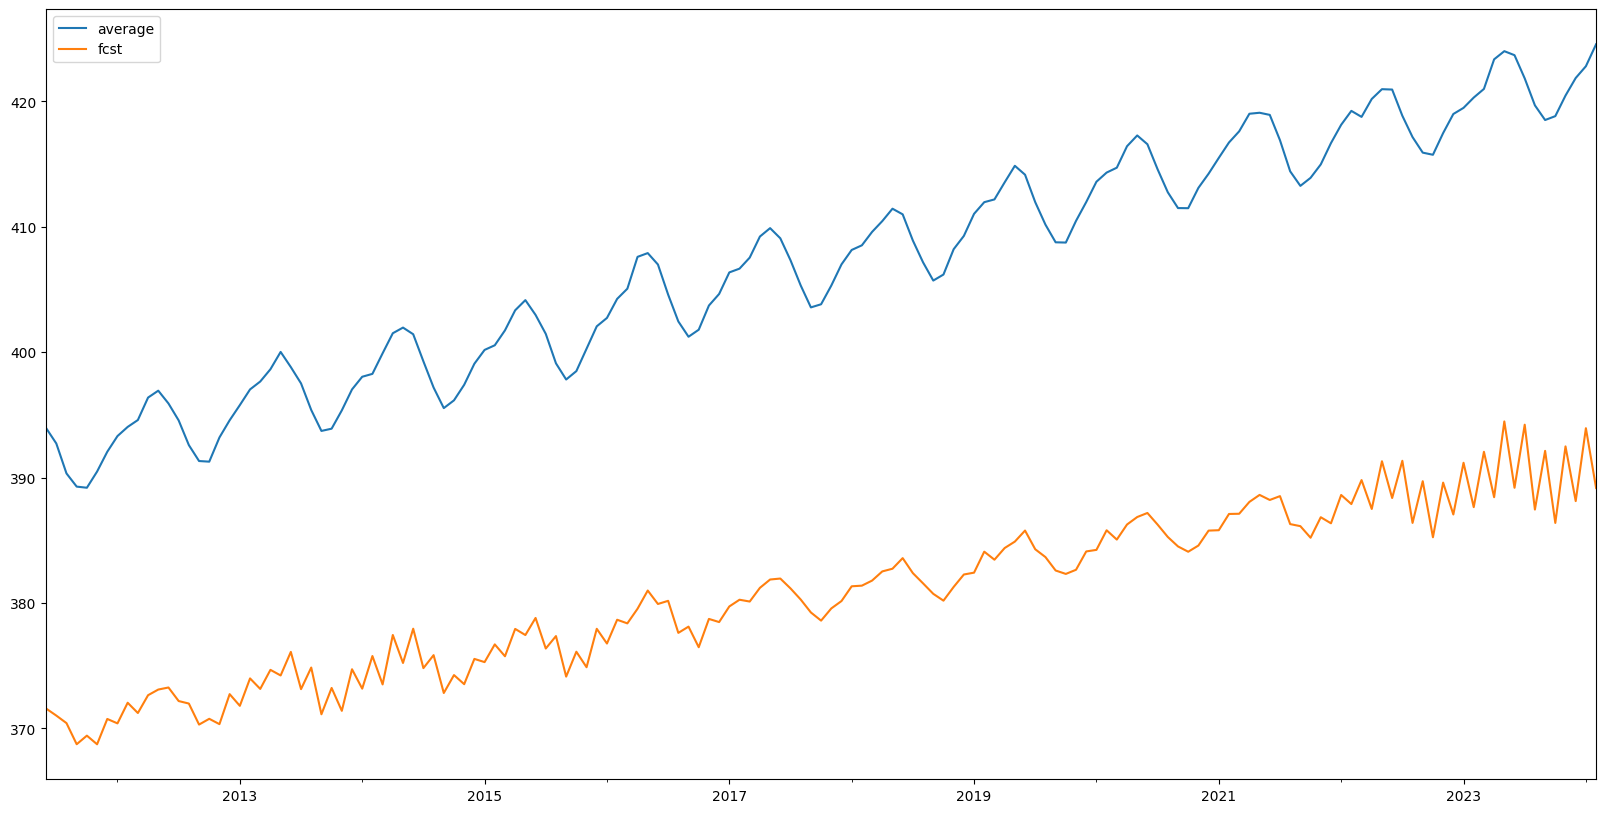

In [22]:
test["fcst"] = fcst
test.plot(figsize = (20,10))
plt.show()

In [23]:
mse_score = mean_squared_error(test['average'], test['fcst'])
print(mse_score)

710.555588585127


                               SARIMAX Results                                
Dep. Variable:                average   No. Observations:                  760
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1022.850
Date:                Thu, 21 Mar 2024   AIC                           2053.700
Time:                        12:22:01   BIC                           2072.233
Sample:                    10-01-1960   HQIC                          2060.836
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        360.5209     85.267      4.228      0.000     193.401     527.641
ar.L1          0.9996      0.002    571.838      0.000       0.996       1.003
ma.L1          0.6563      0.031     21.215      0.0

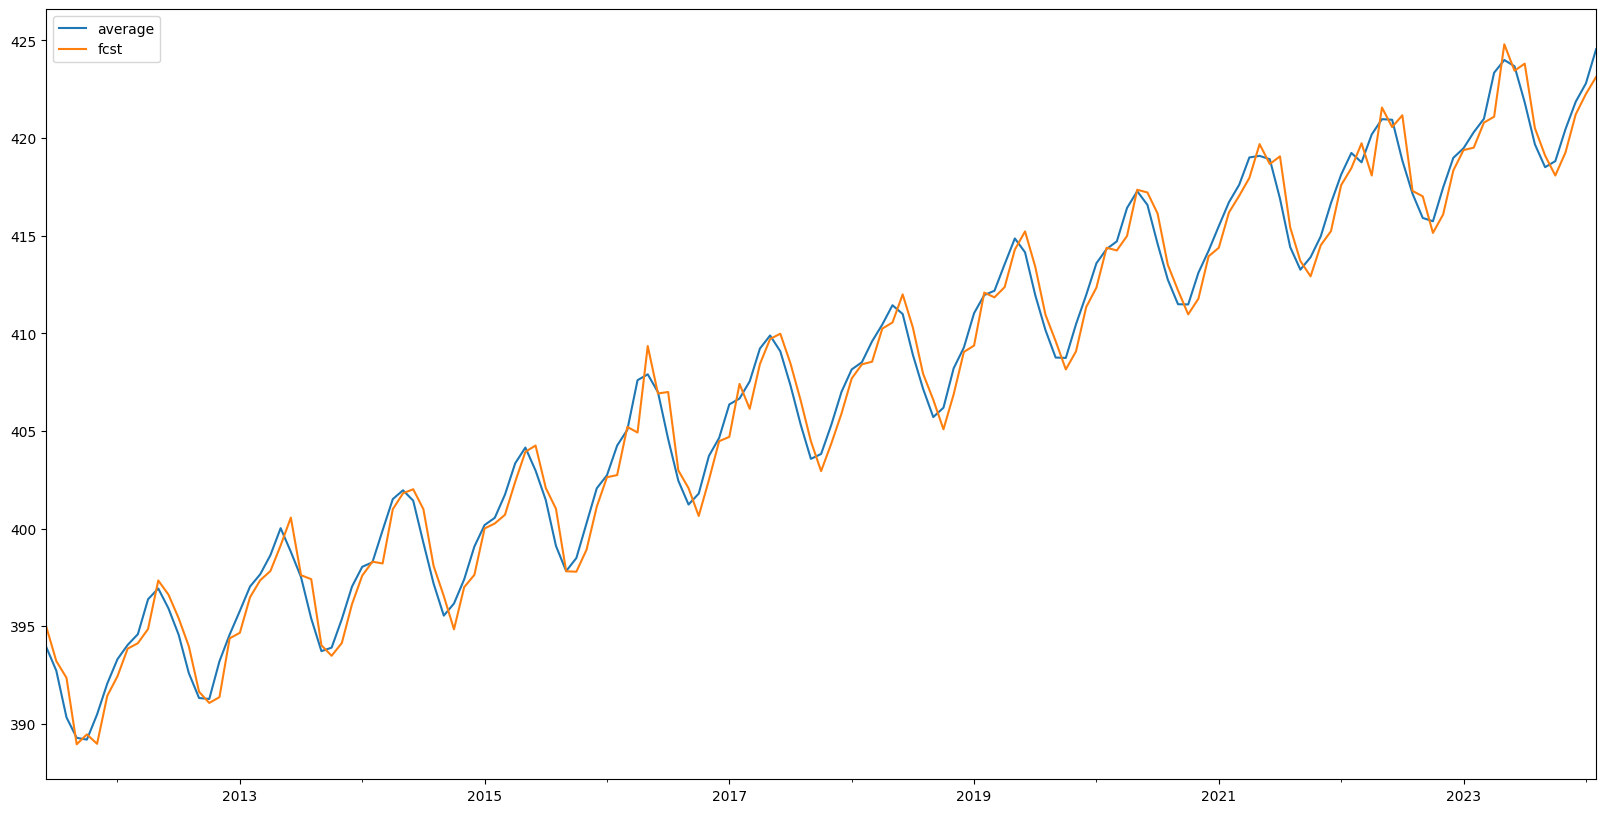

1.0796264363129615


In [24]:
train, test = train_test_split(df, test_size = 0.2,random_state = 13, shuffle = False)
p, d, q = 1,0,1
fcst = []
for step in range(test.shape[0]):
    try:
        arima = ARIMA(train, order = (p,d,q))
        arima_final = arima.fit()
        prediction = arima_final.forecast(steps = 1)
        fcst.append(prediction[0])
        train = train.append(pd.Series(test.iloc[step]))
    except:
        error = -99999
        print("error")
        fcst.append(error)
        tmp = test.iloc[step]
        tmp[0] = error
        train = train.append(pd.Series(tmp))

print(arima_final.summary())

test["fcst"] = fcst
test.plot(figsize = (20,10))
plt.show()

mse_score = mean_squared_error(test['average'], test['fcst'])
print(mse_score)

In [25]:
print(arima_final.summary())

                               SARIMAX Results                                
Dep. Variable:                average   No. Observations:                  760
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1022.850
Date:                Thu, 21 Mar 2024   AIC                           2053.700
Time:                        12:22:01   BIC                           2072.233
Sample:                    10-01-1960   HQIC                          2060.836
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        360.5209     85.267      4.228      0.000     193.401     527.641
ar.L1          0.9996      0.002    571.838      0.000       0.996       1.003
ma.L1          0.6563      0.031     21.215      0.0

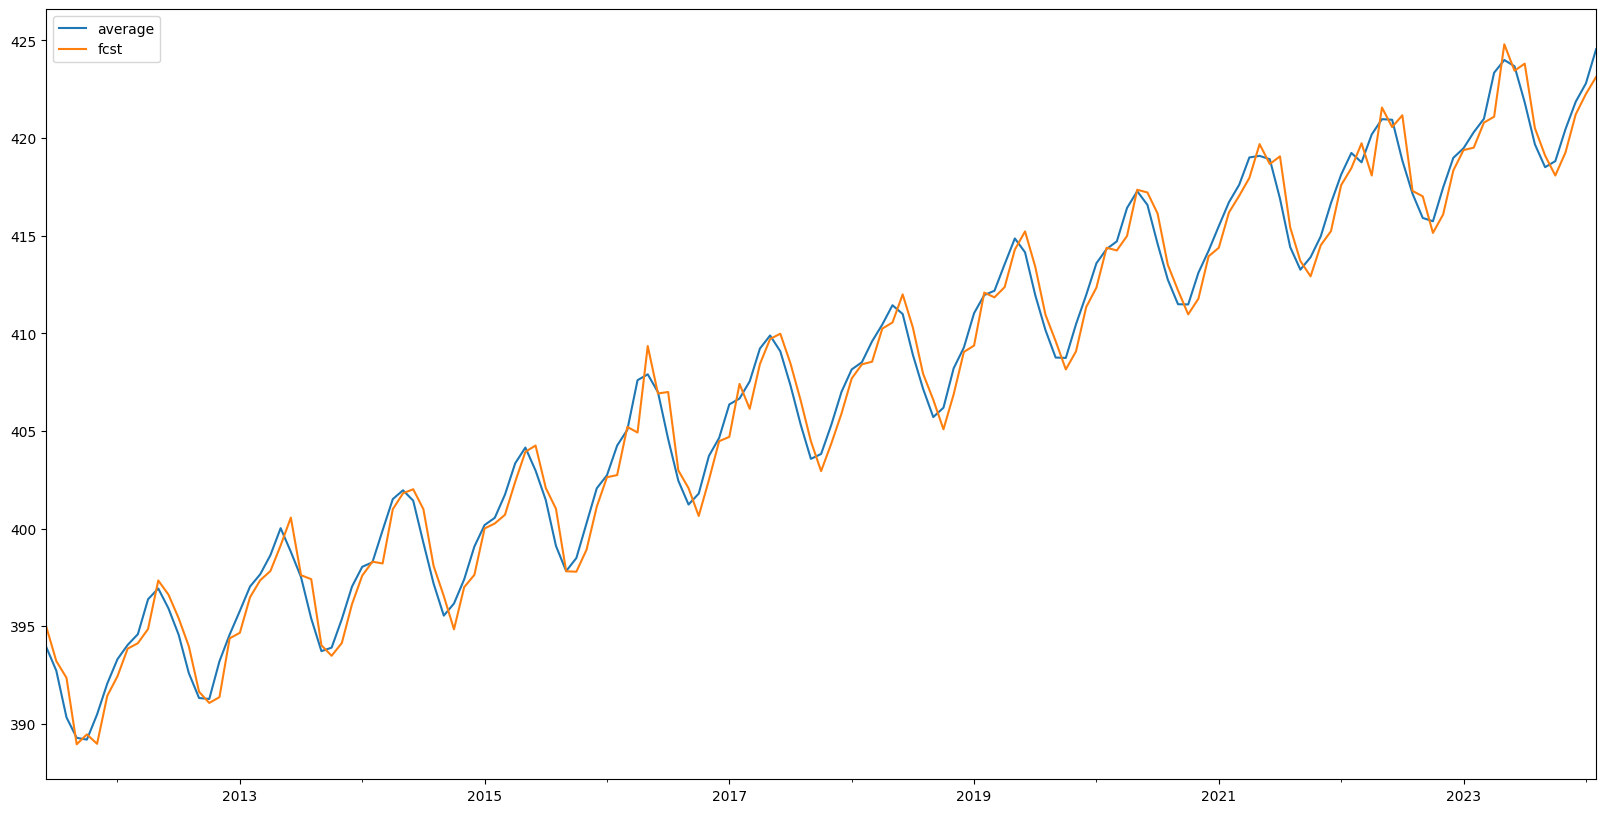

In [26]:
test["fcst"] = fcst
test.plot(figsize = (20,10))
plt.show()

In [27]:
mse_score = mean_squared_error(test['average'], test['fcst'])
print(mse_score)

1.0796264363129615


In [28]:
X = np.array(range(len(df)))
y = df['average'].values
print(X.shape, y.shape)

(761,) (761,)


In [29]:
def prepare_data(data_df, K, T):
  X_train, y_train, X_test, y_test = [], [], [], []
  X_train = data_df.months[:K]
  y_train = data_df.co2_value[:K]
  X_test = data_df.months[K:K+T]
  y_test = data_df.co2_value[K:K+T]

  return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [30]:
data_df = pd.DataFrame({'months': X, 'co2_value': y})

In [31]:
X_train, y_train, X_test, y_test = prepare_data(data_df, 550, 50)

In [32]:
arma_model = ARIMA(y_train, order = (27,0,2))
arma_final = arma_model.fit()
print(arma_final.summary())
arma_predictions = arma_final.predict(start = 0, end = len(X)-1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  550
Model:                ARIMA(27, 0, 2)   Log Likelihood                -155.850
Date:                Thu, 21 Mar 2024   AIC                            373.699
Time:                        12:22:36   BIC                            507.307
Sample:                             0   HQIC                           425.911
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        344.8904      0.001   3.96e+05      0.000     344.889     344.892
ar.L1          0.3774      2.925      0.129      0.897      -5.355       6.110
ar.L2          0.4229      2.136      0.198      0.8

In [33]:
print(X.shape)
print(y.shape)

(761,)
(761,)


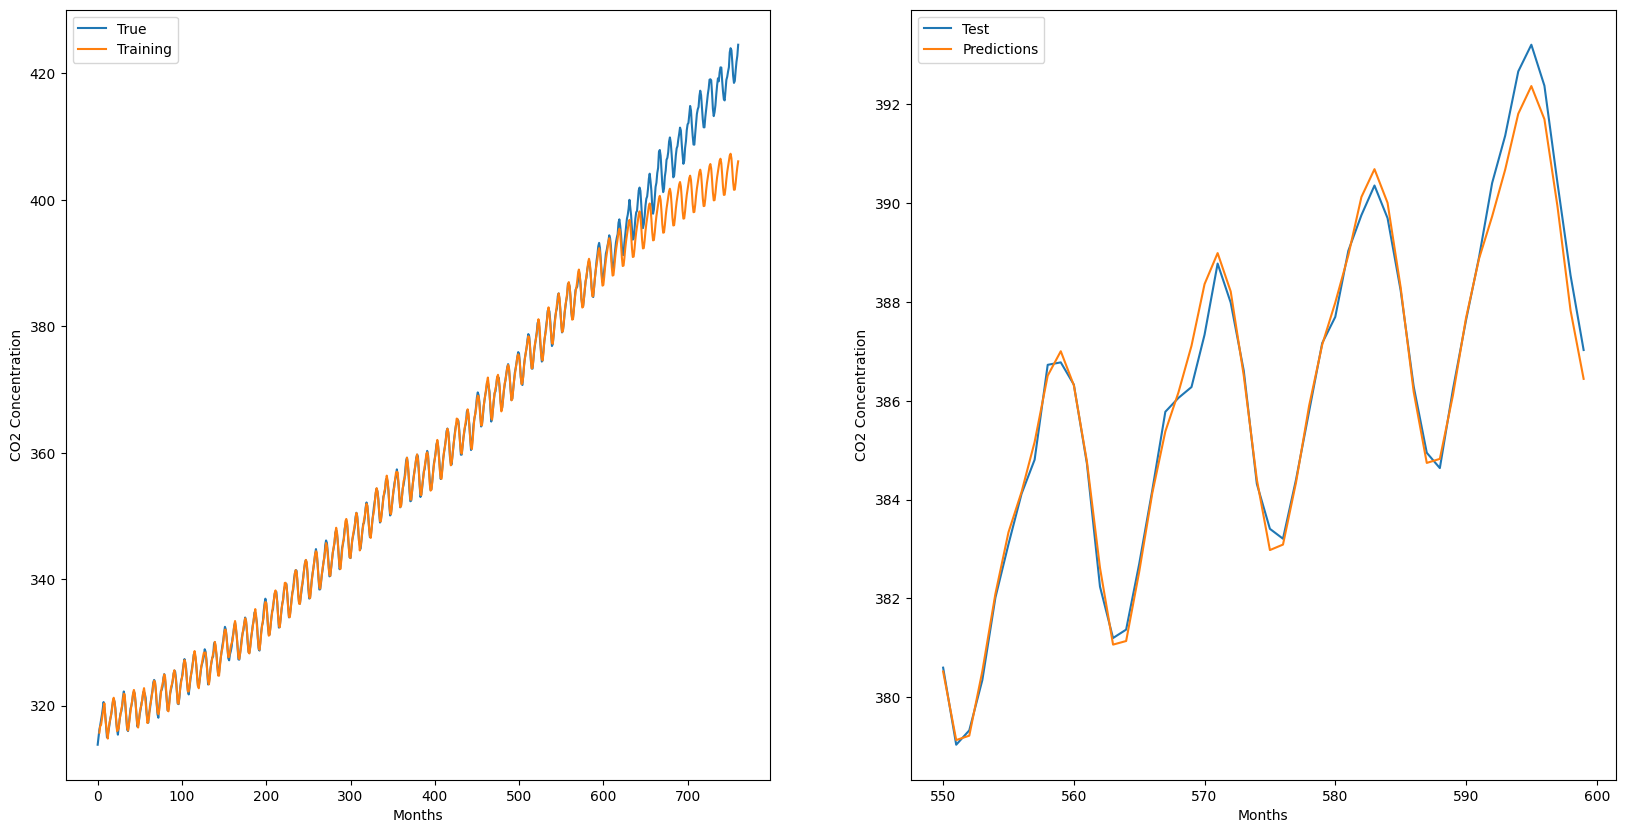

In [34]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.plot(X, y, label = "True")
plt.plot(X[2:], arma_predictions[2:], label = "Training")
plt.xlabel("Months")
plt.ylabel("CO2 Concentration")
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test, y_test, label = "Test")
plt.plot(X_test, arma_predictions[550:600], label = "Predictions")
plt.xlabel("Months")
plt.ylabel("CO2 Concentration")
plt.legend()
plt.show()

In [35]:
ma_model = ARIMA(y_train, order = (0,0,2))
ma_final = ma_model.fit()
print(ma_final.summary())
ma_predictions = ma_final.predict(start = 0, end = len(X)-1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  550
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1710.575
Date:                Thu, 21 Mar 2024   AIC                           3429.150
Time:                        12:22:37   BIC                           3446.390
Sample:                             0   HQIC                          3435.887
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        344.8911      0.873    395.169      0.000     343.181     346.602
ma.L1          1.8286      0.020     90.114      0.000       1.789       1.868
ma.L2          0.9169      0.020     45.164      0.0

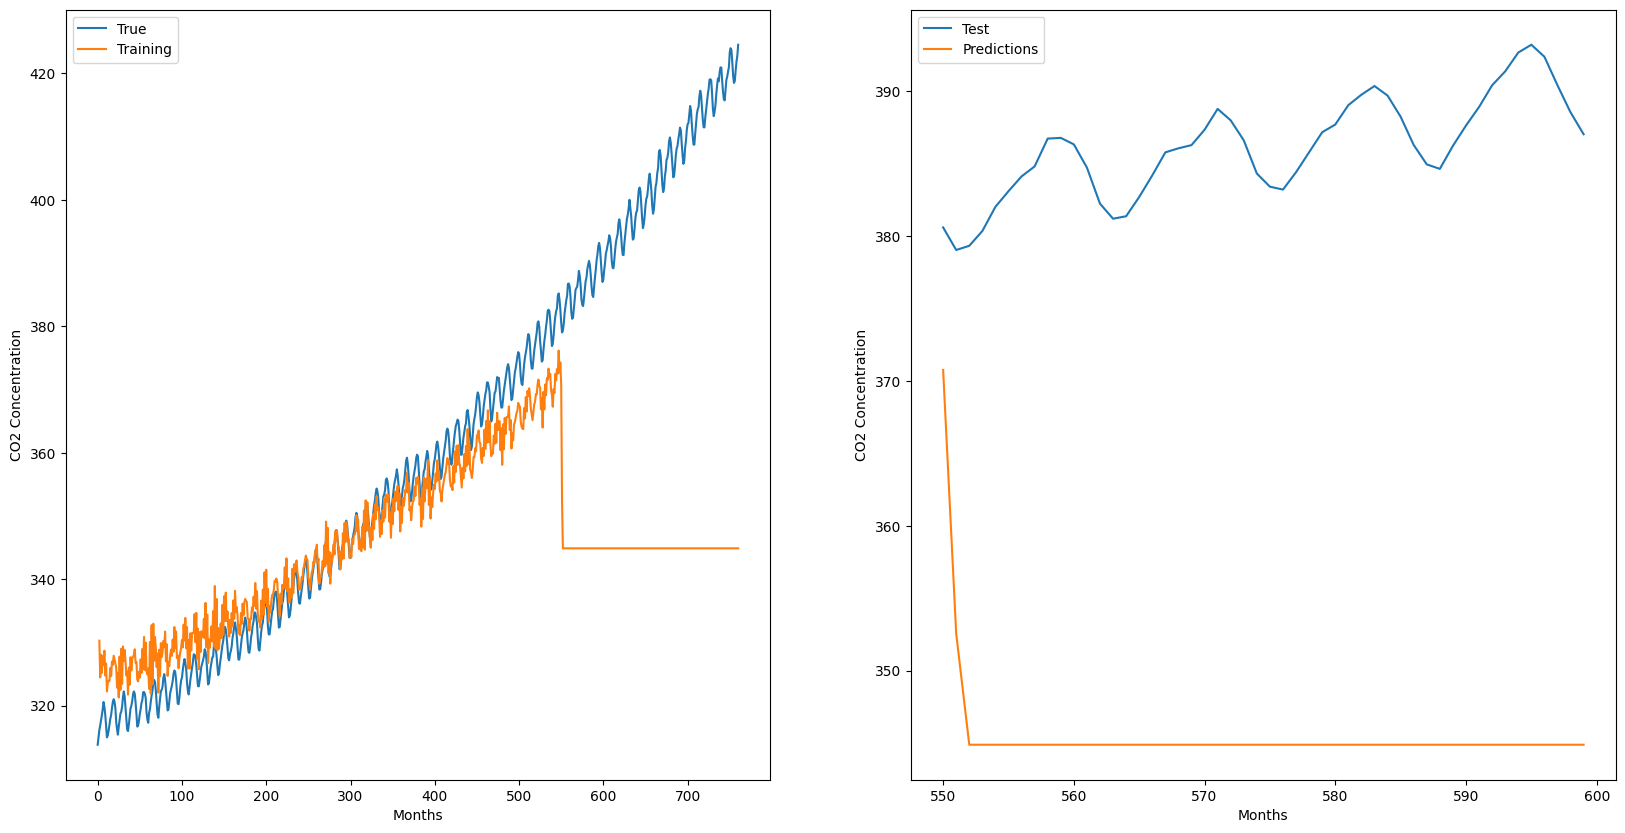

In [36]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.plot(X, y, label = "True")
plt.plot(X[2:], ma_predictions[2:], label = "Training")
plt.xlabel("Months")
plt.ylabel("CO2 Concentration")
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test, y_test, label = "Test")
plt.plot(X_test, ma_predictions[550:600], label = "Predictions")
plt.xlabel("Months")
plt.ylabel("CO2 Concentration")
plt.legend()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  550
Model:                 ARIMA(0, 0, 9)   Log Likelihood                -820.222
Date:                Thu, 21 Mar 2024   AIC                           1662.444
Time:                        12:22:42   BIC                           1709.853
Sample:                             0   HQIC                          1680.971
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        344.8929      1.199    287.652      0.000     342.543     347.243
ma.L1          2.1988      0.037     59.437      0.000       2.126       2.271
ma.L2          3.3275      0.078     42.485      0.0

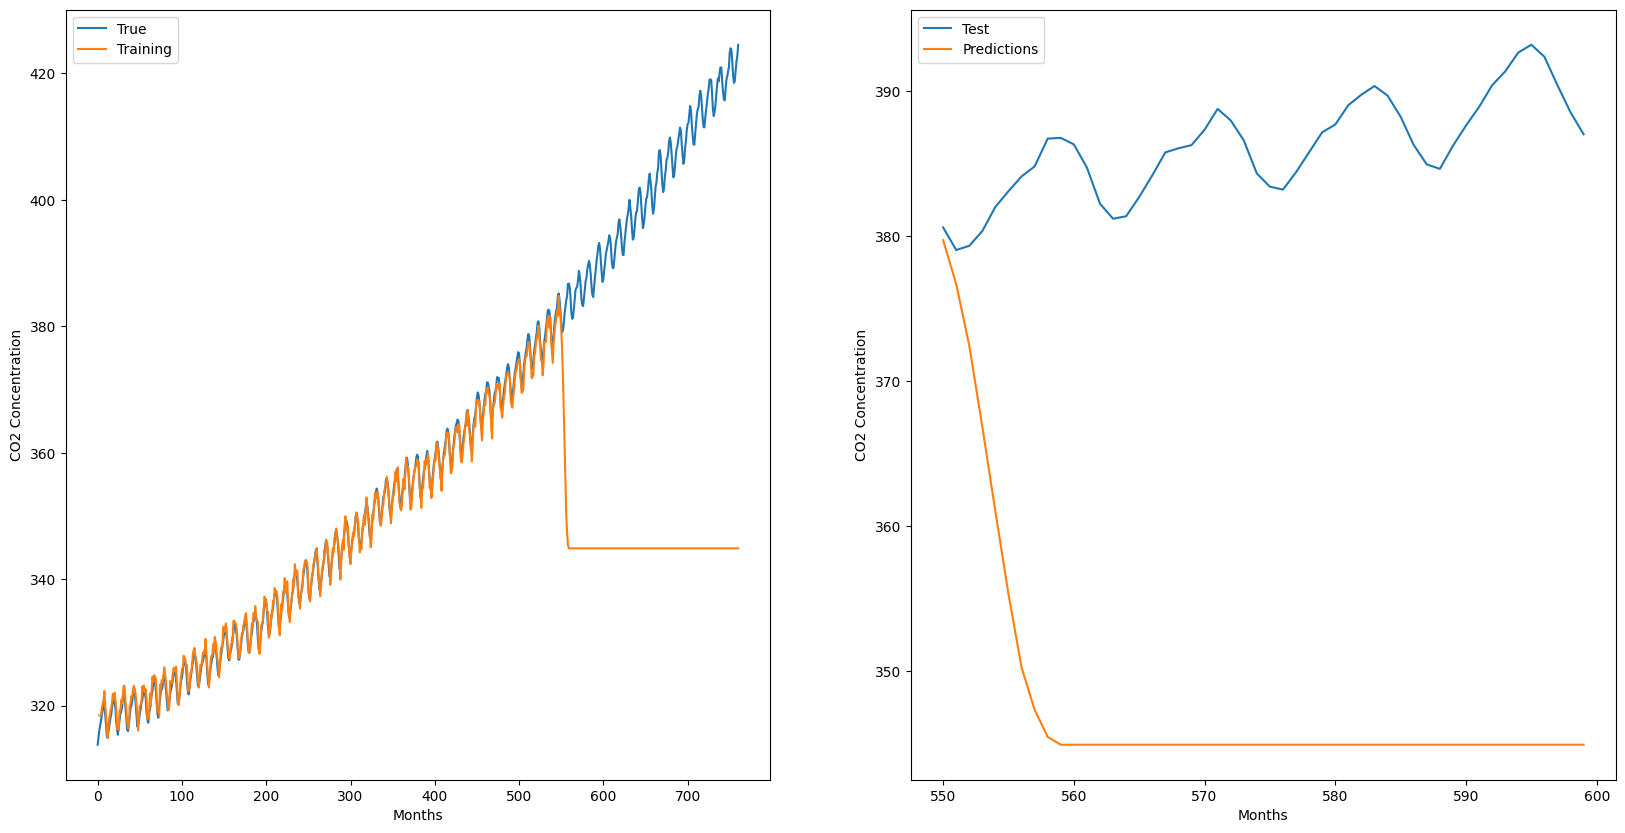

In [37]:
ma_model_2 = ARIMA(y_train, order = (0,0,9))
ma_final_2 = ma_model_2.fit()
print(ma_final_2.summary())
ma_predictions_2 = ma_final_2.predict(start = 0, end = len(X)-1)

plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.plot(X, y, label = "True")
plt.plot(X[2:], ma_predictions_2[2:], label = "Training")
plt.xlabel("Months")
plt.ylabel("CO2 Concentration")
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test, y_test, label = "Test")
plt.plot(X_test, ma_predictions_2[550:600], label = "Predictions")
plt.xlabel("Months")
plt.ylabel("CO2 Concentration")
plt.legend()
plt.show()